In [12]:
# Import necessary libraries

import SimpleITK as sitk
import os
import time
import matplotlib.pyplot as plt
import glob
import natsort
from ipywidgets import interact, fixed
from IPython.display import clear_output 
from tqdm import tqdm
%matplotlib inline
import numpy as np

In [13]:
# Input zone hardcoded variables

path_of_mr_navigators           =               '/Users/lalith/Documents/GAN/MR-navigators' # change this
wild_card_string                =               'Transform_MRnav_*nii'
path_of_tfms                    =               '/Users/lalith/Documents/GAN/MR-navigators';

In [24]:
# Program start


# Utility functions borrowed from Simple ITK's notebook

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

    
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
    
# Paste the two given images together. On the left will be image1 and on the right image2.
# image2 is also centered vertically in the combined image.
def write_combined_image(image1, image2, horizontal_space, file_name):
    combined_image = sitk.Image((image1.GetWidth() + image2.GetWidth() + horizontal_space,
                                max(image1.GetHeight(), image2.GetHeight())), 
                                image1.GetPixelID(), image1.GetNumberOfComponentsPerPixel())
    combined_image = sitk.Paste(combined_image, image1, image1.GetSize(), (0, 0), (0, 0))
    combined_image = sitk.Paste(combined_image, image2, image2.GetSize(), (0, 0), 
                                (image1.GetWidth()+horizontal_space, 
                                 round((combined_image.GetHeight()-image2.GetHeight())/2)))
    sitk.WriteImage(combined_image, file_name)


# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and 
# save an image that includes a visualization of the registered images and
# the metric value plot.    
def save_plot(registration_method, fixed, moving, transform, file_name_prefix):

    #
    # Plotting the similarity metric values, resolution changes are marked with 
    # a blue star.
    #
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)

    # Convert the plot to a SimpleITK image (works with the agg matplotlib backend, doesn't work
    # with the default - the relevant method is canvas_tostring_rgb())
    plt.gcf().canvas.draw()    
    plot_data = np.fromstring(plt.gcf().canvas.tostring_rgb(), dtype=np.uint8, sep='')
    plot_data = plot_data.reshape(plt.gcf().canvas.get_width_height()[::-1] + (3,))
    plot_image = sitk.GetImageFromArray(plot_data, isVector=True)

    
    #
    # Extract the central axial slice from the two volumes, compose it using the transformation
    # and alpha blend it.
    #
    alpha = 0.7
    
    central_index = round((fixed.GetSize())[2]/2)
    
    moving_transformed = sitk.Resample(moving, fixed, transform, 
                                       sitk.sitkLinear, 0.0, 
                                       moving_image.GetPixelIDValue())
    
    # Extract the central slice in xy and alpha blend them                                   
    combined = (1.0 - alpha)*fixed[:,:,central_index] + \
               alpha*moving_transformed[:,:,central_index]

    # Assume the alpha blended images are isotropic and rescale intensity
    # Values so that they are in [0,255], convert the grayscale image to
    # color (r,g,b).
    combined_slices_image = sitk.Cast(sitk.RescaleIntensity(combined), sitk.sitkUInt8)
    combined_slices_image = sitk.Compose(combined_slices_image,
                                         combined_slices_image,
                                         combined_slices_image)

    write_combined_image(combined_slices_image, plot_image, 0, 
                         file_name_prefix + format(len(metric_values), '03d') + '.png')

    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
    
# Registration module

registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)


registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()


# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))


0

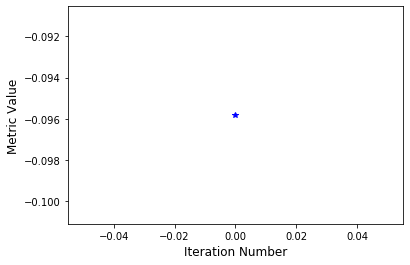

/Users/lalith/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NameError: name 'moving_image' is not defined

  0%|          | 0/13 [00:02<?, ?it/s]


RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: /Users/runner/runners/2.160.0/work/1/sitk/Wrapping/Python/sitkPyCommand.cxx:135:
sitk::ERROR: There was an error executing the Python Callable.

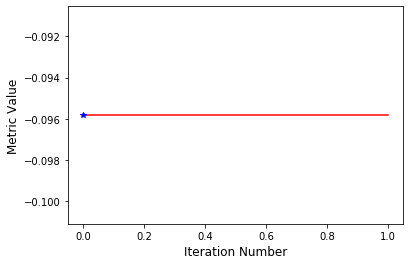

In [25]:
# Registration cycle 

os.chdir(path_of_mr_navigators) # go to the path of the mr navigators 
mr_nav_files                    =               (glob.glob(wild_card_string))
mr_nav_files                    =               (natsort.natsorted(mr_nav_files))
path_fixed_img                  =               os.path.join(path_of_mr_navigators,mr_nav_files[0])
for i in tqdm(range(1,(len(mr_nav_files)))):
    time.sleep(0.5)
    print('Processing '+mr_nav_files[i]+'...')
    path_moving_img             =               os.path.join(path_of_mr_navigators,mr_nav_files[i])
    fixed_img                   =               sitk.ReadImage(path_fixed_img)
    moving_img                  =               sitk.ReadImage(path_moving_img)
    initial_transform           =               sitk.CenteredTransformInitializer(fixed_img, 
                                                                                  moving_img, 
                                                                                  sitk.Euler3DTransform(), 
                                                                                  sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method.SetInitialTransform(initial_transform)
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: save_plot(registration_method, fixed_img, moving_img, initial_transform, 'output/iteration_plot'))
    final_transform             =               registration_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32),sitk.Cast(moving_img, sitk.sitkFloat32))
    tfm_file_name               =               str(i+1)+'->'+str(1)+'.tfm'
    print(final_transform)
    sitk.WriteTransform(final_transform, os.path.join(path_of_tfms, tfm_file_name))

itk::simple::Transform
 AffineTransform (0x7fea914e3760)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 2
   Modified Time: 27978736
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.962757 0.0109912 -0.00348754 
     0.000213898 0.95945 0.00266308 
     0.00326015 -0.0178245 0.929204 
   Offset: [-3.31023, -0.0963924, 4.13743]
   Center: [0, 0, 0]
   Translation: [-3.31023, -0.0963924, 4.13743]
   Inverse: 
     1.03867 -0.0118257 0.0039323 
     -0.000221433 1.04221 -0.00298778 
     -0.00364847 0.0200337 1.07612 
   Singular: 0

